In [10]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import time
import sys
import map

%matplotlib inline

## Helper Functions

In [11]:
def variable_info(variable):
    """
    Provided a variable, prints the type and content of the variable
    """
    print("This variable is a {}".format(type(variable)))
    if type(variable) == np.ndarray:
        print("\n\nThe shape is {}".format(variable.shape))
    print("\n\nThe data contained in the variable is : ")
    print(variable)
    print("\n\nThe elements that can be accessed in the variable are :\n")
    print(dir(variable))
    
variable_info(np.array([1]))

This variable is a <class 'numpy.ndarray'>


The shape is (1,)


The data contained in the variable is : 
[1]


The elements that can be accessed in the variable are :

['T', '__abs__', '__add__', '__and__', '__array__', '__array_finalize__', '__array_function__', '__array_interface__', '__array_prepare__', '__array_priority__', '__array_struct__', '__array_ufunc__', '__array_wrap__', '__bool__', '__class__', '__class_getitem__', '__complex__', '__contains__', '__copy__', '__deepcopy__', '__delattr__', '__delitem__', '__dir__', '__divmod__', '__dlpack__', '__dlpack_device__', '__doc__', '__eq__', '__float__', '__floordiv__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__iadd__', '__iand__', '__ifloordiv__', '__ilshift__', '__imatmul__', '__imod__', '__imul__', '__index__', '__init__', '__init_subclass__', '__int__', '__invert__', '__ior__', '__ipow__', '__irshift__', '__isub__', '__iter__', '__itruediv__', '__ixor__', '__le__', '__len__', '__lshift

## Map Initialisation

Here is the function provided to create an empty plot of the size max_val with the grid lines in the desired positions. You do not need to understand the details of this function as it is purely related to the plotting.

In [12]:
def create_empty_plot(max_val):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val+1, 5)
    minor_ticks = np.arange(0, max_val+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val])
    ax.set_xlim([-1,max_val])
    ax.grid(True)
    
    return fig, ax

In [13]:
def create_empty_plot_xy(max_val_x,max_val_y):
    """
    Helper function to create a figure of the desired dimensions & grid
    
    :param max_val: dimension of the map along the x and y dimensions
    :return: the fig and ax objects.
    """
    fig, ax = plt.subplots(figsize=(7,7))
    
    major_ticks = np.arange(0, max_val_y+1, 5)
    minor_ticks = np.arange(0, max_val_x+1, 1)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    ax.set_yticks(major_ticks)
    ax.set_yticks(minor_ticks, minor=True)
    ax.grid(which='minor', alpha=0.2)
    ax.grid(which='major', alpha=0.5)
    ax.set_ylim([-1,max_val_y])
    ax.set_xlim([-1,max_val_x])
    ax.grid(True)
    
    return fig, ax

To create the map on which we are going to apply the path planning algorithm, we are making use of :
- a random generator that creates a map of size max_val x max_val (defined in the previous cell)
- a random seed to ensure that the ouptut of the random generator is the same at each iteration
- a threshold value which determines for each cell whether it is occupied (i.e. value set to 1) or free (i.e. value set to 0). 

You can play with these parameters to change the size of the map (map_size), density of the obstacles in the map (threshold) as well as their position (random seed). 



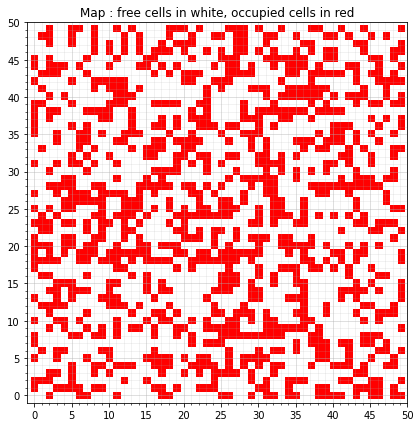

In [14]:
#Creating the grid
max_val = 50 # Size of the map

fig, ax = create_empty_plot(max_val)

# Creating the occupancy grid
np.random.seed(0) # To guarantee the same outcome on all computers
data = np.random.rand(max_val, max_val) * 20 # Create a grid of 50 x 50 random values
cmap = colors.ListedColormap(['white', 'red']) # Select the colors with which to display obstacles and free cells

# Converting the random values into occupied and free cells
limit = 12 
occupancy_grid = data.copy()
occupancy_grid[data>limit] = 1
occupancy_grid[data<=limit] = 0

# Displaying the map
ax.imshow(occupancy_grid.transpose(), cmap=cmap)
plt.title("Map : free cells in white, occupied cells in red");


If you use the default values provided to construct the map, then the outcome of the A* algorithm that you should expect to obtain is the following (with the plotting functions already pre-implemented). 


<img src="Images/Astar_sol.png" alt="Drawing" style="width: 500px;"/>

- white cells : free cells
- red cells : occupied cells
- orange nodes : explored nodes
- blue nodes : nodes corresponding to the optimal path
- green circle : starting node
- purple circle : target node


## Implementing the Algorithm

The following implementation of the A* algorithm is based on the pseudo-code provided here : https://en.wikipedia.org/wiki/A*_search_algorithm#Pseudocode

Make sure that you understand the different steps of the algorithm before starting to implement it. You are free however to choose another pseudo-code that corresponds to the A* algorithm implementation if you feel more comfortable with it. 

The following functions provide the list of possible movements depending on whether you decide to have the algorithm work in a 4 connected or an 8 connected grid ([see here for a table recapitulating the difference](https://edoras.sdsu.edu/doc/matlab/toolbox/images/morph12.html)). You do not need to edit anything in these functions.

In [15]:
def _get_movements_4n():
    """
    Get all possible 4-connectivity movements (up, down, left right).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0)]

def _get_movements_8n():
    """
    Get all possible 8-connectivity movements. Equivalent to get_movements_in_radius(1)
    (up, down, left, right and the 4 diagonals).
    :return: list of movements with cost [(dx, dy, movement_cost)]
    """
    s2 = math.sqrt(2)
    return [(1, 0, 1.0),
            (0, 1, 1.0),
            (-1, 0, 1.0),
            (0, -1, 1.0),
            (1, 1, s2),
            (-1, 1, s2),
            (-1, -1, s2),
            (1, -1, s2)]

Now you can implement the A* algorithm using either the pseudo-code provided and following the structure below or selecting another one.

In [16]:
def reconstruct_path(cameFrom, current):
    """
    Recurrently reconstructs the path from start node to the current node
    :param cameFrom: map (dictionary) containing for each node n the node immediately 
                     preceding it on the cheapest path from start to n 
                     currently known.
    :param current: current node (x, y)
    :return: list of nodes from start to current node
    """
    total_path = [current]
    while current in cameFrom.keys():
        # Add where the current node came from to the start of the list
        total_path.insert(0, cameFrom[current]) 
        current=cameFrom[current]
    return total_path

def A_Star(start, goal, h, coords, occupancy_grid, movement_type, max_val_x, max_val_y):
    """
    A* for 2D occupancy grid. Finds a path from start to goal.
    h is the heuristic function. h(n) estimates the cost to reach goal from node n.
    :param start: start node (x, y)
    :param goal_m: goal node (x, y)
    :param occupancy_grid: the grid map
    :param movement: select between 4-connectivity ('4N') and 8-connectivity ('8N', default)
    :return: a tuple that contains: (the resulting path in meters, the resulting path in data array indices)
    """
    
    # -----------------------------------------
    # DO NOT EDIT THIS PORTION OF CODE
    # -----------------------------------------
    
    # Check if the start and goal are within the boundaries of the map
    '''for point in [start, goal]:
        for coord in point:
            assert coord>=0 and coord<max_val, "start or end goal not contained in the map" '''

    assert start[0]>=0 and start[0]<max_val_x and start[1]>=0 and start[1]<max_val_y, "start not contained in the map"
            
    assert goal[0]>=0 and goal[0]<max_val_x and goal[1]>=0 and goal[1]<max_val_y, "end goal not contained in the map"        
    
    # check if start and goal nodes correspond to free spaces
    if occupancy_grid[start[0], start[1]]:
        raise Exception('Start node is not traversable')

    if occupancy_grid[goal[0], goal[1]]:
        raise Exception('Goal node is not traversable')
    
    # get the possible movements corresponding to the selected connectivity
    if movement_type == '4N':
        movements = _get_movements_4n()
    elif movement_type == '8N':
        movements = _get_movements_8n()
    else:
        raise ValueError('Unknown movement')
    
    # --------------------------------------------------------------------------------------------
    # A* Algorithm implementation - feel free to change the structure / use another pseudo-code
    # --------------------------------------------------------------------------------------------
    
    # The set of visited nodes that need to be (re-)expanded, i.e. for which the neighbors need to be explored
    # Initially, only the start node is known.
    openSet = [start]
    
    # The set of visited nodes that no longer need to be expanded.
    closedSet = []

    # For node n, cameFrom[n] is the node immediately preceding it on the cheapest path from start to n currently known.
    cameFrom = dict()

    # For node n, gScore[n] is the cost of the cheapest path from start to n currently known.
    gScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    gScore[start] = 0

    # For node n, fScore[n] := gScore[n] + h(n). map with default value of Infinity
    fScore = dict(zip(coords, [np.inf for x in range(len(coords))]))
    fScore[start] = h[start]
    #fScore[start] = h(start)
    # while there are still elements to investigate
    while openSet != []:
        
        #the node in openSet having the lowest fScore[] value
        fScore_openSet = {key:val for (key,val) in fScore.items() if key in openSet}
        current = min(fScore_openSet, key=fScore_openSet.get)
        del fScore_openSet
        
        #If the goal is reached, reconstruct and return the obtained path
        if current == goal:
            return reconstruct_path(cameFrom, current), closedSet

        openSet.remove(current)
        closedSet.append(current)
        
        #for each neighbor of current:
        for dx, dy, deltacost in movements:
            
            neighbor = (current[0]+dx, current[1]+dy)
            
            # if the node is not in the map, skip
            #continue skip ce tour de boucle et commence le prochain
            if (neighbor[0] >= occupancy_grid.shape[0]) or (neighbor[1] >= occupancy_grid.shape[1]) or (neighbor[0] < 0) or (neighbor[1] < 0):
                continue
            
            # if the node is occupied or has already been visited, skip
            if (occupancy_grid[neighbor[0], neighbor[1]]) or (neighbor in closedSet): 
                continue
            # neighbor is in the map, not in a occupied block or already visited
            
            # d(current,neighbor) is the weight of the edge from current to neighbor
            # tentative_gScore is the distance from start to the neighbor through current
            tentative_gScore = gScore[current] + deltacost
            # deltacost permet d aller de current vers neighbor?
            if neighbor not in openSet:
                openSet.append(neighbor)
                
            if tentative_gScore < gScore[neighbor]:
                # This path to neighbor is better than any previous one. Record it!
                cameFrom[neighbor] = current
                gScore[neighbor] = tentative_gScore
                 
    # Open set is empty but goal was never reached
    print("No path found to goal")
    return [], closedSet


In [17]:
    start = (0,0)
    goal = (10,10)
    
'''    for point in [start, goal]:
        for p in point:
            #p = int(p)
            #print(p)
            print(p<1)
            print(int(p[0]),int(p[1]))'''
#print(start[0])


'    for point in [start, goal]:\n    for p in point:\n        #p = int(p)\n        #print(p)\n        print(p<1)\n        print(int(p[0]),int(p[1]))'

No path found to goal


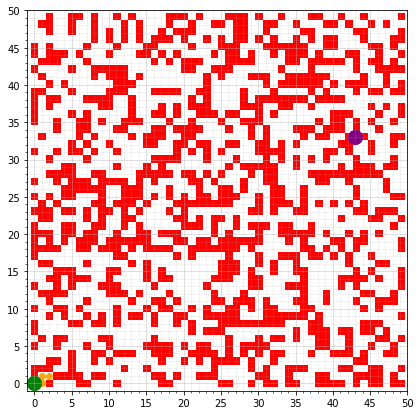

In [19]:
# Define the start and end goal
start = (0,0)
goal = (43,33)



# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
x,y = np.mgrid[0:max_val:1, 0:max_val:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))
coords = list([(int(x[0]), int(x[1])) for x in pos])

# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid, "4N", max_val,max_val)
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot(max_val)
ax_astar.imshow(occupancy_grid.transpose(), cmap=cmap)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);

<blockquote>

<span style="color: #2980B9 ;">
    
Note that the heursitic here was chosen to be the Euclidian distance between the starting point and the goal. The choice of heuristic guides the search and will determine the speed at which the local optimum is found. A bad heursitic, such as a Manhattan distance in an 8 connected grid will however prevent you from finding the optimal solution because it does not take diagonals into account. 


</blockquote>

[[10 10 10 10 10 10 10 10 10 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
  25 26 27 28 29 30 31 31 32 33 34 35 36 37 38 39 40]
 [10 11 12 13 14 15 16 17 18 19 19 19 19 19 19 19 19 19 19 19 19 19 19 19
  19 19 19 19 19 19 19 20 20 20 20 20 20 20 20 20 20]]


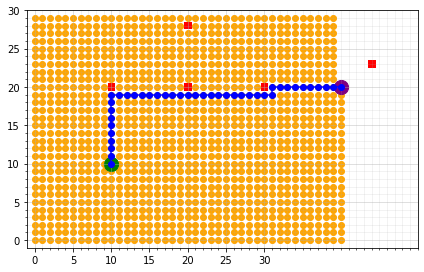

In [20]:
# Define the start and end goal
start = (10,10)
goal = (40,20)

max_val_x = 50
max_val_y = 30
occupancy_grid2 = np.zeros((50,30))
occupancy_grid2[20,20] = 1
occupancy_grid2[10,20] = 1
occupancy_grid2[20,28] = 1
occupancy_grid2[30,20] = 1
occupancy_grid2[44,23] = 1
# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
x,y = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))


# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid2, "4N",max_val_x,max_val_y)
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot_xy(max_val_x,max_val_y)
ax_astar.imshow(occupancy_grid2.transpose(), cmap=cmap)

print(path)
# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);

In [54]:
# tranform path which is list of nodes to list of movements
# list_mvt = 0 up, 1 down, 2 right, 3 left
left =[-1., 0.]
right =[1., 0.]
up =[0., 1.]
down =[0., -1.]
'''for x in path:
    print(x)'''
list_mvt = np.zeros(nbr_positions)
#print(path.shape)
shape = path.shape
nbr_positions = shape[1]
#path = path.reshape((41,2))
reshaped_path = path.transpose()
#reshaped_path = path.reshape((shape[1],shape[0]))
list_diff = np.zeros((shape[1],shape[0]))
#print(path)
'''for pos in reshaped_path:
    print(pos)'''
print('path',reshaped_path)
for idx_pos in range(nbr_positions):
    actual_pos = reshaped_path [idx_pos]
    next_pos = reshaped_path [min(nbr_positions-1,idx_pos+1)]
    print('actual_pos', actual_pos,'next_pos',next_pos)
    diff = next_pos-actual_pos
    list_diff[idx_pos]=diff
    print(diff)
    
    if np.array_equiv(diff,up):
        list_mvt[idx_pos] = 0  
    if np.array_equiv(diff,down):
        list_mvt[idx_pos] = 1    
    if np.array_equiv(diff,right):
        list_mvt[idx_pos] = 2    
    if np.array_equiv(diff,left):
        list_mvt[idx_pos] = 3
print(list_mvt)
    # call fct which mvt
    #print(actual_pos)
    

path [[10 10]
 [10 11]
 [10 12]
 [10 13]
 [10 14]
 [10 15]
 [10 16]
 [10 17]
 [10 18]
 [10 19]
 [11 19]
 [12 19]
 [13 19]
 [14 19]
 [15 19]
 [16 19]
 [17 19]
 [18 19]
 [19 19]
 [20 19]
 [21 19]
 [22 19]
 [23 19]
 [24 19]
 [25 19]
 [26 19]
 [27 19]
 [28 19]
 [29 19]
 [30 19]
 [31 19]
 [31 20]
 [32 20]
 [33 20]
 [34 20]
 [35 20]
 [36 20]
 [37 20]
 [38 20]
 [39 20]
 [40 20]]
actual_pos [10 10] next_pos [10 11]
[0 1]
actual_pos [10 11] next_pos [10 12]
[0 1]
actual_pos [10 12] next_pos [10 13]
[0 1]
actual_pos [10 13] next_pos [10 14]
[0 1]
actual_pos [10 14] next_pos [10 15]
[0 1]
actual_pos [10 15] next_pos [10 16]
[0 1]
actual_pos [10 16] next_pos [10 17]
[0 1]
actual_pos [10 17] next_pos [10 18]
[0 1]
actual_pos [10 18] next_pos [10 19]
[0 1]
actual_pos [10 19] next_pos [11 19]
[1 0]
actual_pos [11 19] next_pos [12 19]
[1 0]
actual_pos [12 19] next_pos [13 19]
[1 0]
actual_pos [13 19] next_pos [14 19]
[1 0]
actual_pos [14 19] next_pos [15 19]
[1 0]
actual_pos [15 19] next_pos [16 19]
[

In [21]:
'''# Define the start and end goal
start = (10,10)
goal = (40,20)

max_val_x = 50
max_val_y = 30
occupancy_grid2 = np.zeros((50,30))
occupancy_grid2 = 
# -----------------------------------------
# DO NOT EDIT THIS PORTION OF CODE - 
# EXECUTION AND PLOTTING OF THE ALGORITHM
# -----------------------------------------
    
    
# List of all coordinates in the grid
x,y = np.mgrid[0:max_val_x:1, 0:max_val_y:1]
pos = np.empty(x.shape + (2,))
pos[:, :, 0] = x; pos[:, :, 1] = y
pos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))


# Define the heuristic, here = distance to goal ignoring obstacles
h = np.linalg.norm(pos - goal, axis=-1)
h = dict(zip(coords, h))

# Run the A* algorithm
path, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid2, "4N",max_val_x,max_val_y)
path = np.array(path).reshape(-1, 2).transpose()
visitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()

# Displaying the map
fig_astar, ax_astar = create_empty_plot_xy(max_val_x,max_val_y)
ax_astar.imshow(occupancy_grid2.transpose(), cmap=cmap)

print(path)

# Plot the best path found and the list of visited nodes
ax_astar.scatter(visitedNodes[0], visitedNodes[1], marker="o", color = 'orange');
ax_astar.plot(path[0], path[1], marker="o", color = 'blue');
ax_astar.scatter(start[0], start[1], marker="o", color = 'green', s=200);
ax_astar.scatter(goal[0], goal[1], marker="o", color = 'purple', s=200);'''

'# Define the start and end goal\nstart = (10,10)\ngoal = (40,20)\n\nmax_val_x = 50\nmax_val_y = 30\noccupancy_grid2 = np.zeros((50,30))\noccupancy_grid2 = \n# -----------------------------------------\n# DO NOT EDIT THIS PORTION OF CODE - \n# EXECUTION AND PLOTTING OF THE ALGORITHM\n# -----------------------------------------\n    \n    \n# List of all coordinates in the grid\nx,y = np.mgrid[0:max_val_x:1, 0:max_val_y:1]\npos = np.empty(x.shape + (2,))\npos[:, :, 0] = x; pos[:, :, 1] = y\npos = np.reshape(pos, (x.shape[0]*x.shape[1], 2))\n\n\n# Define the heuristic, here = distance to goal ignoring obstacles\nh = np.linalg.norm(pos - goal, axis=-1)\nh = dict(zip(coords, h))\n\n# Run the A* algorithm\npath, visitedNodes = A_Star(start, goal, h, coords, occupancy_grid2, "4N",max_val_x,max_val_y)\npath = np.array(path).reshape(-1, 2).transpose()\nvisitedNodes = np.array(visitedNodes).reshape(-1, 2).transpose()\n\n# Displaying the map\nfig_astar, ax_astar = create_empty_plot_xy(max_val_x,